In [25]:
import networkx as nx
import numpy as np
import scipy as sp
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities
from community import community_louvain
import pandas as pd
from tqdm import tqdm

Load proteins and remove the 4932 prefix

In [26]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)
print(f"number of nodes in original dataset: ", len(G0.nodes))

#removing the prefix in proteins
map_dic = {}

for node in G0.nodes() :
    map_dic[node] = node[5:]
   
G = nx.relabel_nodes(G0, map_dic)

# remove essential proteins
essential_proteins = pd.read_csv("yeast essential proteins.csv", header=None)[1]
print()
print(essential_proteins)
G.remove_nodes_from(essential_proteins)
print(f"number of nodes after removing essential proteins: ", len(G.nodes))    

number of nodes in original dataset:  6394

0         YAL001C
1         YAL003W
2         YAL012W
3         YAL025C
4         YAL032C
          ...    
1308    YKL138C-A
1309    YNL138W-A
1310    YNL024C-A
1311    YHR199C-A
1312    YIL102C-A
Name: 1, Length: 1313, dtype: object
number of nodes after removing essential proteins:  5098


In [27]:
print("Number of edges in original dataset", len(G.edges))

Number of edges in original dataset 517875


Remove edges below a fixed score.

In [28]:
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 500
for edge in G.edges: 
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G.remove_edge(edge[0],edge[1])
print("Number of edges after filtering over low score", len(G.edges))

Number of edges after filtering over low score 99189


In [29]:
partLouvain = community_louvain.best_partition(G)
number_of_communities = max(partLouvain.values())+1 #We add one because the indexing starts at 0.
print('# of partitions for Louvain modularity =',number_of_communities)

# of partitions for Louvain modularity = 322


In [30]:
# Let's construct a dictionary object called 'communities'. The keys will be the community labels and the values 
# will be a list of nodes in that community. The more experienced python users among you will probably see an 
# easier/faster way to do this.

communities = {} #empty dictionary
for i in range(number_of_communities):
    communities[i] = [] #create an empty list for each community

for name, community in partLouvain.items():
    communities[community].append(name) #go through the computed partition and add each node to the appropriate list
    

# The dictionary we have constructed is similar to what the output of the Louvain algorithm in NetworkX would be. 
# In your own investigations you can decide what is more useful.

#Now let's find out how big each community is. You could accomplish this in the following way:
for k in communities:
    print('The size of community #', list(communities.keys())[k], 'is ',len(communities[k]))

The size of community # 0 is  1
The size of community # 1 is  1
The size of community # 2 is  296
The size of community # 3 is  573
The size of community # 4 is  302
The size of community # 5 is  422
The size of community # 6 is  1
The size of community # 7 is  916
The size of community # 8 is  1
The size of community # 9 is  565
The size of community # 10 is  1
The size of community # 11 is  1
The size of community # 12 is  516
The size of community # 13 is  166
The size of community # 14 is  410
The size of community # 15 is  1
The size of community # 16 is  145
The size of community # 17 is  476
The size of community # 18 is  1
The size of community # 19 is  1
The size of community # 20 is  1
The size of community # 21 is  1
The size of community # 22 is  1
The size of community # 23 is  1
The size of community # 24 is  1
The size of community # 25 is  1
The size of community # 26 is  1
The size of community # 27 is  1
The size of community # 28 is  1
The size of community # 29 is  

In [31]:

# partLouvain is a dict where the keys are the node names (i.e. protein names) and values are the index of the community that the protein is part of

protein_interest = set(['YER178W', 'YBR221C', 'YNL071W', 'YOR090C', 'YFL018C', 'YIL042C', 'YGL059W'])
communities_interest = set()

for p in protein_interest:
    print(f"protein {p} in community {partLouvain[p]}")
    communities_interest.add(partLouvain[p])

protein YGL059W in community 12
protein YFL018C in community 7
protein YOR090C in community 12
protein YER178W in community 7
protein YBR221C in community 7
protein YNL071W in community 7
protein YIL042C in community 12


In [32]:
communities_interest

{7, 12}

In [33]:
# add proteins of interest in the list below
protein_interest = set(['YER178W', 'YBR221C', 'YNL071W', 'YOR090C', 'YFL018C', 'YIL042C', 'YGL059W'])
degree_dic = {}

for p in protein_interest:
    degree_dic[p] = float(G.degree(p))
    
print("degree of each protein")
dict(sorted(degree_dic.items(), key=lambda item: item[1]))

degree of each protein


{'YGL059W': 35.0,
 'YIL042C': 39.0,
 'YOR090C': 52.0,
 'YNL071W': 89.0,
 'YFL018C': 96.0,
 'YER178W': 116.0,
 'YBR221C': 144.0}

100%|████████████████████████████████████████| 322/322 [00:01<00:00, 228.48it/s]


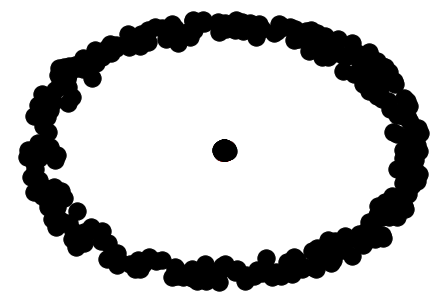

In [34]:
# goal make sure that community 1 and 4 are connecting
# define the clusters as separate graphs

#subgraph dict with community label as key and subgraph as value
essential_proteins_cluster = {}

for key in communities.keys():
    essential_proteins_cluster[key] = G.subgraph(communities[key])

layout_PPI = nx.spring_layout(G,k=1/np.sqrt(len(G)))

for i in tqdm(range(len(essential_proteins_cluster))):
    nx.draw(essential_proteins_cluster[i], pos=layout_PPI, node_color='red' if i in communities_interest else 'black')
    
    
# nx.draw(essential_proteins_cluster[1],pos=layout_PPI,node_color='red')
# nx.draw(essential_proteins_cluster[4],pos=layout_PPI,node_color='green')

In [35]:
#edges dict with community label as key and (0,1) for edge/no-edge as value
edges = {}
for i in range(number_of_communities-1):
    for j in range(i+1,number_of_communities):
        edges[str(i)+str(j)] = 0

for i in range(number_of_communities-1):
    for node in essential_proteins_cluster[i].nodes():
        for neighbor in G.neighbors(node):
            for j in range(i+1,number_of_communities):
                if neighbor in communities[j]:
                    edges[str(i)+str(j)] += 1

# print(edges) # convention: 'ij' denotes the edge between node(=community) i and node(=community) j.

In [36]:

# Find the communities which have links to the community of the target community
def get_connected_communities(community_index):

    neighbor_community = []
    for i in range(number_of_communities):
        if i < target_community:
            if edges[str(i)+str(target_community)] != 0:
                neighbor_community.append(i)
        if i > target_community:
            if edges[str(target_community)+str(i)] != 0:
                neighbor_community.append(i)
    return neighbor_community


target_community = partLouvain['YOR090C']
print(f"community {target_community} is connected to communities {get_connected_communities(target_community)}")

target_community = partLouvain['YER178W']
print(f"community {target_community} is connected to communities {get_connected_communities(target_community)}")

community 12 is connected to communities [2, 3, 4, 5, 7, 9, 13, 14, 16, 17]
community 7 is connected to communities [2, 3, 4, 5, 9, 12, 13, 14, 16, 17]


In [37]:
print(G.has_edge('YER178W','YOR090C'))

True
